In [1]:
import torch
import numpy as np
import random
import torch.optim as optim
from model import *
from algorithms import *
from dataset import *
from utils import *
from tabulate import tabulate
from matplotlib import pyplot as plt
import csv

### Fit ground-truth model h

In [2]:
device = 'cpu'
data = QuadraticDataset(device = device)

In [3]:
ctv = torch.zeros(3)
ctv[[0,1]] = 1
print(ctv)

tensor([1., 1., 0.])


In [4]:
test_acc = 0
for i in range(10):
    np.random.seed(i)
    torch.manual_seed(i)
    random.seed(i)
    h = MLP(3,[3,2])
    optimizer = optim.Adam(h.parameters(), lr=0.05, weight_decay=1e-4)
    device = 'cpu'
    batch_size = 256
    n_epochs = 50
    test_acc += trainer_h(h, data, optimizer, device, n_epochs, batch_size)


Training:   0%|          | 0/50 [00:00<?, ?epochs/s]

Training: 100%|██████████| 50/50 [00:02<00:00, 17.22epochs/s]

Validation Accuracy of the model: 96.56%
Testing Accuracy of the model: 95.88%


In [ ]:
print(f'average model testng accuracy is {test_acc:4.2f}% ')

### Hyper parameters selection: Logistic


In [5]:
def log_model_runner(dataset, hp, seeds, mode='baseline'):
    train, val, test = generate_res()

    for i in range(len(seeds)):
        print('training seed', seeds[i] ,'started')
        random.seed(seeds[i])
        np.random.seed(seeds[i])
        torch.manual_seed(seeds[i]) 

        model = logReg(dataset.XZ_train.shape[1])
        model = model.to(device)
        
        lr = hp['learning_rate']
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        
        if mode == 'baseline':
            results = trainer_baselines(
                model,
                h,
                dataset,
                optimizer,
                device,
                n_epochs=hp['n_epochs'],
                batch_size=hp['batch_size'], 
                z_blind=False,
                metric=hp['metric'], 
                lambda_=hp['lambda_'],
                delta_effort=hp['delta_effort'],
                ctv = ctv
            )


        else:
            results = trainer_new(
                model,
                h,
                dataset,
                optimizer,
                device,
                n_epochs=hp['n_epochs'],
                batch_size=hp['batch_size'], 
                z_blind=False,
                delta_effort=hp['delta_effort'],
                lambda2_ = hp['lambda2'],
                lambda3_ = hp['lambda3'],
                ctv = ctv,
                add_safe = hp['add_safe']
            )      
        
        append_res(train,results.train_imp_all[-1],results.train_imp_a[-1], results.train_imp_b[-1], results.train_safety[-1],results.train_aw_a[-1], results.train_aw_b[-1],results.train_aw_all[-1],results.train_acc_hist[-1],results.train_ei_hist[-1],results.train_be_hist[-1],results.train_dp_hist[-1],results.train_eo_hist[-1],results.train_eodd_hist[-1])
        append_res(val,results.val_imp_all,results.val_imp_a, results.val_imp_b, results.val_safety, results.val_aw_a, results.val_aw_b, results.val_aw_all,results.val_acc, results.val_ei,results.val_be,results.val_dp,results.val_eo,results.val_eodd)
        append_res(test,results.test_imp_all,results.test_imp_a, results.test_imp_b, results.test_safety, results.test_aw_a, results.test_aw_b, results.test_aw_all, results.test_acc,results.test_ei,results.test_be,results.test_dp,results.test_eo,results.test_eodd)

    res_train = get_res(train)
    res_val = get_res(val)
    res_test = get_res(test)
    print('Training finished for all seeds.')
    
    return res_train, res_val, res_test



def log_hyperparameter_test_imp(dataset, hp_test, seed=[0], mode='new'):
    hp = hp_test.copy()
    result = []
    for i in hp_test['learning_rate']:
        for k in hp_test['lambda2']:
            for j in hp_test['lambda3']:
                c = []
                hp['learning_rate'] = i
                hp['lambda2'] = k
                hp['lambda3'] = j
                train, val, _ = log_model_runner(dataset, hp, seeds=seed, mode=mode)
                c.append(hp['learning_rate'])
                c.append(hp['lambda2'])
                c.append(hp['lambda3'])
                c.append(train['accuracy_mean'])
                c.append(val['accuracy_mean'])
                c.append(val['imp_all_mean'])
                c.append(val['safety_mean'])
                c.append(val['swf_mean'])
                c.append(val['aw_all_mean'])
                c.append(val['ei_mean'])
                c.append(val['be_mean'])
                c.append(val['dp_mean'])
                c.append(val['eo_mean'])
                c.append(val['eodd_mean'])
                result.append(c)
    print(tabulate(result, headers=['learning_rate', 'lambda2_', 'lambda3_','accuracy_train', 'accuracy_val','imp_all','safety','swf',
                                    'aw','ei', 'be', 'dp', 'eo', 'eodd']))


In [ ]:

IMP_hp_test = {}
IMP_hp_test['learning_rate'] = [0.001,0.01,0.1]
IMP_hp_test['lambda2'] = [0,0.1]
IMP_hp_test['lambda3'] = [0,0.1]
IMP_hp_test['n_epochs'] = 50
IMP_hp_test['batch_size'] = 512
IMP_hp_test['delta_effort'] = 0.1
IMP_hp_test['add_safe'] = True
log_hyperparameter_test_imp(data, IMP_hp_test, seed=[0])

- According to the table, we choose learning rate = 0.01. 

- Next we test lambda1, lambda2

### Testing the influence of lambda1, lambda2

- In this section, we make either lambda1, lambda2 0, and inspect the changes of the other parameter

In [155]:
def log_effect_result(dataset, hp_test, seed=[0], mode='new', prefix = 'lambda1'):
    hp = hp_test.copy()
    result = {'lambda2':[],'lambda3':[],'DW':[],'DW_var':[],'IMP':[],'IMP_var':[],'SF':[],'SF_var':[],'AW':[],'AW_var':[], 'SWF':[],'SWF_var':[]}
    for i in hp_test['lambda2']:
        for k in hp_test['lambda3']:
            hp['lambda2'] = i
            hp['lambda3'] = k
            _,_ ,test = log_model_runner(dataset, hp, seeds=seed, mode=mode)
            result['lambda2'].append(i)
            result['lambda3'].append(k)
            result['DW'].append(test['accuracy_mean'])
            result['DW_var'].append(test['accuracy_var'])
            result['IMP'].append(test['imp_all_mean'])
            result['IMP_var'].append(test['imp_all_var'])
            result['SF'].append(test['safety_mean'])
            result['SF_var'].append(test['safety_var'])
            result['SWF'].append(test['swf_mean'])
            result['SWF_var'].append(test['swf_var'])                      
            result['AW'].append(test['aw_all_mean'])
            result['AW_var'].append(test['aw_all_var'])

    # write them into a csv for reuse
    with open(f'saved_texts/quad_{prefix}.csv', 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
    
        # Writing headers
        headers = [key for key in result.keys()]
        writer.writerow(headers)
    
        # Writing data
        for row in zip(*result.values()):
            writer.writerow(row)
    return result

 
def plot_effect_test(result, content = 'lambda2', ebar=False, pos = 'best', bb = (0,0)):
    """
    plot the effects of lambda2 or lambda3 only using the testing data
    specifically, the plot consists of: 1) DW; 2) SWF = imp_all + min(imp_a, imp_b); 3) AW = aw_all
    """
    
    plt.figure(figsize = (3,2.5))

    if content == 'lambda2':
        x = result['lambda2']
        plt.xlabel(r'$\lambda_1$')
    else:
        x = result['lambda3']
        plt.xlabel(r'$\lambda_2$')

    if not ebar:
        plt.plot(x,result['DW'], marker = 'o', color = 'red', label = 'DW')
        # plt.plot(x,result['IMP'], marker = 'o', color = 'blue', label = 'IMP')
        plt.plot(x,result['SWF'], marker = 'o', color = 'green', label = 'SWF')
        # plt.plot(x,result['SF'], marker = 'o', color = 'green', label = 'SF')
        plt.plot(x,result['AW'], marker = 'o', color = 'black', label = 'AW')
        if bb != (0,0):
            plt.legend(handlelength=1,bbox_to_anchor=bb)
        else:
            plt.legend(handlelength=1,loc = pos)
        plt.tight_layout()
        plt.savefig(f'saved_plots/quad_welfare_vary{content}.pdf')

    
    else:
        plt.errorbar(x,result['DW'], yerr=result['DW_var'],marker = 'o', markersize=3,color = 'red', label = 'DW')
        plt.errorbar(x,result['SWF'], yerr=result['SWF_var'],marker = 'o',markersize=3, color = 'green', label = 'SWF')
        # plt.errorbar(x,result['IMP'], yerr=result['IMP_var'],marker = 'o', color = 'blue', label = 'IMP')
        # plt.errorbar(x,result['SF'], yerr=result['SF_var'],marker = 'o', color = 'green', label = 'SF')
        plt.errorbar(x,result['AW'], yerr=result['AW_var'],marker = 'o',markersize=3, color = 'black', label = 'AW')
        if bb != (0,0):
            plt.legend(handlelength=1,bbox_to_anchor=bb)
        else:
            plt.legend(handlelength=1,loc = pos)
        plt.tight_layout()
        plt.savefig(f'saved_plots/ebar_quad_welfare_vary{content}.pdf')

        

In [144]:
IMP_hp_test = {}
IMP_hp_test['learning_rate'] = 0.01
IMP_hp_test['lambda2'] = np.linspace(0,2,5)
IMP_hp_test['lambda3'] = [0]
IMP_hp_test['n_epochs'] = 50
IMP_hp_test['batch_size'] = 512
IMP_hp_test['delta_effort'] = 0.1
IMP_hp_test['add_safe'] = True
res_l1 = log_effect_result(data, IMP_hp_test, seed=[0,1,2,3,4,5,6], mode='new')

IMP_hp_test = {}
IMP_hp_test['learning_rate'] = 0.01
IMP_hp_test['lambda2'] = [0]
IMP_hp_test['lambda3'] = np.linspace(0,2,5)
IMP_hp_test['n_epochs'] = 50
IMP_hp_test['batch_size'] = 512
IMP_hp_test['delta_effort'] = 0.1
IMP_hp_test['add_safe'] = True
res_l2 = log_effect_result(data, IMP_hp_test, seed=[0,1,2,3,4,5,6], mode='new',prefix='lambda2')

training seed 0 started


Training:   0%|          | 0/50 [00:00<?, ?epochs/s]

Training: 100%|██████████| 50/50 [00:03<00:00, 13.55epochs/s]


training seed 1 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.79epochs/s]


training seed 2 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.08epochs/s]


training seed 3 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.58epochs/s]


training seed 4 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.09epochs/s]


training seed 5 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.09epochs/s]


training seed 6 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.82epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.46epochs/s]


training seed 1 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.82epochs/s]


training seed 2 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.78epochs/s]


training seed 3 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.90epochs/s]


training seed 4 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.16epochs/s]


training seed 5 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.88epochs/s]


training seed 6 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.58epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.04epochs/s]


training seed 1 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.16epochs/s]


training seed 2 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.77epochs/s]


training seed 3 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.09epochs/s]


training seed 4 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.94epochs/s]


training seed 5 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.10epochs/s]


training seed 6 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.97epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.01epochs/s]


training seed 1 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.63epochs/s]


training seed 2 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.33epochs/s]


training seed 3 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.05epochs/s]


training seed 4 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.07epochs/s]


training seed 5 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.43epochs/s]


training seed 6 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.79epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.54epochs/s]


training seed 1 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.83epochs/s]


training seed 2 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.38epochs/s]


training seed 3 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.91epochs/s]


training seed 4 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.39epochs/s]


training seed 5 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.38epochs/s]


training seed 6 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.52epochs/s]

Training finished for all seeds.


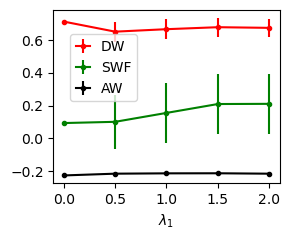

In [156]:
# plot dw, swf, aw relative to lambda1
plot_effect_test(res_l1, ebar=True,bb = (0.4,0.9))

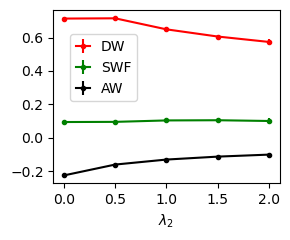

In [157]:
# plot dw, swf, aw relative to lambda2
plot_effect_test(res_l2, content='lambda3',ebar=True,bb=(0.4,0.9))

- The results show that when other hyper parameters are fixed, increasing either $\lambda_1, \lambda_2$ incur expected outcomes



### Separately testing IMP and SF

In above 2 plots, we can see the tradeoff between dw, swf and aw. The confliction between SWF and AW seem to be smaller than other pairs

Now, specifically, if we change the objective of SWF to only include IMP, will safety be sacrificed?


In [126]:
IMP_hp_test = {}
IMP_hp_test['learning_rate'] = 0.01
IMP_hp_test['lambda2'] = np.linspace(0,2,5)
IMP_hp_test['lambda3'] = [0]
IMP_hp_test['n_epochs'] = 50
IMP_hp_test['batch_size'] = 512
IMP_hp_test['delta_effort'] = 0.1
IMP_hp_test['add_safe'] = False
res_l3 = log_effect_result(data, IMP_hp_test, seed=[0,1,2,3,4,5,6], mode='new')

training seed 0 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.45epochs/s]


training seed 1 started


Training: 100%|██████████| 50/50 [00:03<00:00, 13.29epochs/s]


training seed 2 started


Training: 100%|██████████| 50/50 [00:03<00:00, 12.74epochs/s]


training seed 3 started


Training: 100%|██████████| 50/50 [00:03<00:00, 13.54epochs/s]


training seed 4 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.30epochs/s]


training seed 5 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.41epochs/s]


training seed 6 started


Training: 100%|██████████| 50/50 [00:03<00:00, 13.86epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.49epochs/s]


training seed 1 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.51epochs/s]


training seed 2 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.05epochs/s]


training seed 3 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.22epochs/s]


training seed 4 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.38epochs/s]


training seed 5 started


Training: 100%|██████████| 50/50 [00:03<00:00, 12.80epochs/s]


training seed 6 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.03epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.78epochs/s]


training seed 1 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.86epochs/s]


training seed 2 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.75epochs/s]


training seed 3 started


Training: 100%|██████████| 50/50 [00:03<00:00, 13.72epochs/s]


training seed 4 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.64epochs/s]


training seed 5 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.33epochs/s]


training seed 6 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.82epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.80epochs/s]


training seed 1 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.10epochs/s]


training seed 2 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.73epochs/s]


training seed 3 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.95epochs/s]


training seed 4 started


Training: 100%|██████████| 50/50 [00:03<00:00, 13.93epochs/s]


training seed 5 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.59epochs/s]


training seed 6 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.25epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.10epochs/s]


training seed 1 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.87epochs/s]


training seed 2 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.17epochs/s]


training seed 3 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.41epochs/s]


training seed 4 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.88epochs/s]


training seed 5 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.87epochs/s]


training seed 6 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.89epochs/s]

Training finished for all seeds.


In [127]:
def plot_imp_safe(res1, res2, ebar=False, pos = 'best', bb = (0,0)):
    """
    plot the effects of lambda2 or lambda3 only using the testing data
    specifically, the plot consists of: 1) DW; 2) SWF = imp_all + min(imp_a, imp_b); 3) AW = aw_all
    """
    
    plt.figure(figsize = (4,3))

    x = res1['lambda2']
    plt.xlabel(r'$\lambda_1$')
    plt.ylabel('SF')

    if not ebar:
        plt.plot(x,res1['SF'], marker = 'o', color = 'blue', label = r'$L_{SWF} = L_{IMP} + L_{SF}$')
        plt.plot(x,res2['SF'], marker = 's', color = 'red', label = r'$L_{SWF} = L_{IMP}$')
        if bb != (0,0):
            plt.legend(handlelength=1,bbox_to_anchor=bb)
        else:
            plt.legend(handlelength=1,loc = pos)
        plt.tight_layout()
        plt.savefig(f'saved_plots/quad_imp_sf.pdf')

    
    else:
        plt.errorbar(x,res1['SF'], yerr=res1['SF_var'],marker = 'o', color = 'blue', label = 'IMP')
        plt.errorbar(x,res2['SF'], yerr=res2['SF_var'],marker = 's', color = 'red', label = 'SF')
        if bb != (0,0):
            plt.legend(handlelength=1,bbox_to_anchor=bb)
        else:
            plt.legend(handlelength=1,loc = pos)
        plt.tight_layout()
        plt.savefig(f'saved_plots/ebar_quad_imp_sf.pdf')

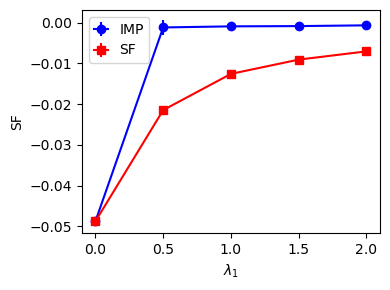

In [153]:
plot_imp_safe(res_l1, res_l3, ebar=True)

### Select the best policy $f$ by summing all welfare up

In [ ]:
def log_best_test(dataset, hp_test, seed=[0], mode='new'):
    hp = hp_test.copy()
    result = []
    for i in hp_test['learning_rate']:
        for k in hp_test['lambda2']:
            for j in hp_test['lambda3']:
                c = []
                hp['learning_rate'] = i
                hp['lambda2'] = k
                hp['lambda3'] = j
                train, val, _ = log_model_runner(dataset, hp, seeds=seed, mode=mode)
                c.append(hp['learning_rate'])
                c.append(hp['lambda2'])
                c.append(hp['lambda3'])
                c.append(train['accuracy_mean'])
                c.append(val['accuracy_mean'])
                c.append(val['swf_mean'])
                c.append(val['aw_all_mean'])
                c.append(val['aw_all_mean'] + val['swf_mean'] + val['accuracy_mean'])
                result.append(c)
    print(tabulate(result, headers=['learning_rate', 'lambda2_', 'lambda3_','accuracy_train', 'accuracy_val','swf',
                                    'aw','total_welfare']))

In [ ]:
IMP_hp_test = {}
IMP_hp_test['learning_rate'] = [0.01]
IMP_hp_test['lambda2'] = np.linspace(0,2,6)
IMP_hp_test['lambda3'] = np.linspace(0,2,6)
IMP_hp_test['n_epochs'] = 50
IMP_hp_test['batch_size'] = 512
IMP_hp_test['delta_effort'] = 0.1
IMP_hp_test['add_safe'] = True
log_best_test(data, IMP_hp_test, seed=[0])

Thus, we finally select learning rate = 0.01, lambda1 = 0.4, lambda2 = 0.8 with total welfare = 0.98

### Compare with other algos

### Final test different policies: 
- StratWelfare: learning rate = 0.01, lambda1 = 0.4, lambda2 = 0.8
- Model = ERM, EI, BE, Safe
- EI, BE, Safe: lambda_ = 0.1 

In [6]:
def experiment_runner(dataset, ERM_hp, IMP_hp, Safe_hp, EI_hp, BE_hp,seeds):
    
    _, _, ERM = log_model_runner(dataset, ERM_hp, seeds, mode='baseline')
    _, _, STWF = log_model_runner(dataset, IMP_hp, seeds, mode='new')
    _, _, EI = log_model_runner(dataset, EI_hp, seeds, mode='baseline')
    _, _, SAFE = log_model_runner(dataset, Safe_hp, seeds, mode='baseline')
    _, _, BE = log_model_runner(dataset, BE_hp, seeds, mode='baseline')
    
    return ERM, STWF, EI, SAFE, BE


Safe_hp = {}
Safe_hp['learning_rate'] = 0.01
Safe_hp['lambda_'] = 0.1
Safe_hp['n_epochs'] = 50
Safe_hp['batch_size'] = 512
Safe_hp['metric'] = 'SAFE'
Safe_hp['delta_effort'] = 0.1

EI_hp = {}
EI_hp['learning_rate'] = 0.01
EI_hp['lambda_'] = 0.1
EI_hp['n_epochs'] = 50
EI_hp['batch_size'] = 512
EI_hp['metric'] = 'EI'
EI_hp['delta_effort'] = 0.1

BE_hp = {}
BE_hp['learning_rate'] = 0.01
BE_hp['lambda_'] = 0.1
BE_hp['n_epochs'] = 50
BE_hp['batch_size'] = 512
BE_hp['metric'] = 'BE'
BE_hp['delta_effort'] = 0.1

ERM_hp = {}
ERM_hp['learning_rate'] = 0.01
ERM_hp['lambda_'] = 0
ERM_hp['n_epochs'] = 50
ERM_hp['batch_size'] = 512
ERM_hp['metric'] = 'ERM'
ERM_hp['delta_effort'] = 0.1

IMP_hp = {}
IMP_hp['learning_rate'] = 0.01
IMP_hp['lambda2'] = 0.4
IMP_hp['lambda3'] = 0.8
IMP_hp['n_epochs'] = 50
IMP_hp['batch_size'] = 512
IMP_hp['metric'] = 'IMP'
IMP_hp['delta_effort'] = 0.1
IMP_hp['add_safe'] = True

ERM, STWF, EI, SAFE, BE = experiment_runner(data, ERM_hp, IMP_hp, Safe_hp, EI_hp, BE_hp, range(0,20,1))

training seed 0 started


Training:   0%|          | 0/50 [00:00<?, ?epochs/s]/Users/tianxie/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tianxie/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Training: 100%|██████████| 50/50 [00:02<00:00, 16.97epochs/s]


training seed 1 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.26epochs/s]


training seed 2 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.33epochs/s]


training seed 3 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.55epochs/s]


training seed 4 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.36epochs/s]


training seed 5 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.82epochs/s]


training seed 6 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.77epochs/s]


training seed 7 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.62epochs/s]


training seed 8 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.08epochs/s]


training seed 9 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.47epochs/s]


training seed 10 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.65epochs/s]


training seed 11 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.59epochs/s]


training seed 12 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.29epochs/s]


training seed 13 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.00epochs/s]


training seed 14 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.34epochs/s]


training seed 15 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.42epochs/s]


training seed 16 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.83epochs/s]


training seed 17 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.28epochs/s]


training seed 18 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.57epochs/s]


training seed 19 started


Training: 100%|██████████| 50/50 [00:02<00:00, 18.73epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.48epochs/s]


training seed 1 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.52epochs/s]


training seed 2 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.26epochs/s]


training seed 3 started


Training: 100%|██████████| 50/50 [00:03<00:00, 13.86epochs/s]


training seed 4 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.58epochs/s]


training seed 5 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.85epochs/s]


training seed 6 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.43epochs/s]


training seed 7 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.32epochs/s]


training seed 8 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.02epochs/s]


training seed 9 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.40epochs/s]


training seed 10 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.60epochs/s]


training seed 11 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.35epochs/s]


training seed 12 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.68epochs/s]


training seed 13 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.25epochs/s]


training seed 14 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.35epochs/s]


training seed 15 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.41epochs/s]


training seed 16 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.43epochs/s]


training seed 17 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.41epochs/s]


training seed 18 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.62epochs/s]


training seed 19 started


Training: 100%|██████████| 50/50 [00:03<00:00, 13.92epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.58epochs/s]


training seed 1 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.97epochs/s]


training seed 2 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.10epochs/s]


training seed 3 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.31epochs/s]


training seed 4 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.61epochs/s]


training seed 5 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.66epochs/s]


training seed 6 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.55epochs/s]


training seed 7 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.74epochs/s]


training seed 8 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.23epochs/s]


training seed 9 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.18epochs/s]


training seed 10 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.16epochs/s]


training seed 11 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.47epochs/s]


training seed 12 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.52epochs/s]


training seed 13 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.72epochs/s]


training seed 14 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.66epochs/s]


training seed 15 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.08epochs/s]


training seed 16 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.72epochs/s]


training seed 17 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.90epochs/s]


training seed 18 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.88epochs/s]


training seed 19 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.84epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.26epochs/s]


training seed 1 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.24epochs/s]


training seed 2 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.05epochs/s]


training seed 3 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.03epochs/s]


training seed 4 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.17epochs/s]


training seed 5 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.98epochs/s]


training seed 6 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.27epochs/s]


training seed 7 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.34epochs/s]


training seed 8 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.31epochs/s]


training seed 9 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.31epochs/s]


training seed 10 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.28epochs/s]


training seed 11 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.30epochs/s]


training seed 12 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.11epochs/s]


training seed 13 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.58epochs/s]


training seed 14 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.86epochs/s]


training seed 15 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.85epochs/s]


training seed 16 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.95epochs/s]


training seed 17 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.93epochs/s]


training seed 18 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.94epochs/s]


training seed 19 started


Training: 100%|██████████| 50/50 [00:03<00:00, 15.03epochs/s]


Training finished for all seeds.
training seed 0 started


Training: 100%|██████████| 50/50 [00:03<00:00, 13.81epochs/s]


training seed 1 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.06epochs/s]


training seed 2 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.51epochs/s]


training seed 3 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.63epochs/s]


training seed 4 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.33epochs/s]


training seed 5 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.63epochs/s]


training seed 6 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.40epochs/s]


training seed 7 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.45epochs/s]


training seed 8 started


Training: 100%|██████████| 50/50 [00:03<00:00, 13.37epochs/s]


training seed 9 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.53epochs/s]


training seed 10 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.38epochs/s]


training seed 11 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.74epochs/s]


training seed 12 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.92epochs/s]


training seed 13 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.76epochs/s]


training seed 14 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.00epochs/s]


training seed 15 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.21epochs/s]


training seed 16 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.23epochs/s]


training seed 17 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.27epochs/s]


training seed 18 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.52epochs/s]


training seed 19 started


Training: 100%|██████████| 50/50 [00:03<00:00, 14.36epochs/s]

Training finished for all seeds.


In [7]:
result = []
models = ["ERM", "STWF",  "SAFE", "EI", "BE"]
sol = [ERM, STWF, EI, SAFE, BE]
for i in range(len(models)):
    c = []
    c.append(models[i])
    res = sol[i]
    c.append(res['accuracy_mean'])
    c.append(res['accuracy_var'])
    c.append(res['swf_mean'])
    c.append(res['swf_var']) 
    c.append(res['safety_mean'])
    c.append(res['safety_var']) 
    c.append(res['aw_all_mean'])
    c.append(res['aw_all_var'])
    c.append(res['ei_mean'])
    c.append(res['ei_var'])
    c.append(res['be_mean'])
    c.append(res['be_var'])
    c.append(res['dp_mean'])
    c.append(res['dp_var'])
    c.append(res['eo_mean'])
    c.append(res['eo_var'])
    c.append(res['eodd_mean'])
    c.append(res['eodd_var'])
    result.append(c)

print(tabulate(result, headers=["model","accuracy_mean","accuracy_var","swf_mean","swf_var","safety_mean","safety_var","aw_all_mean","aw_all_var",
                                "ei_mean","ei_var","be_mean","be_var", "dp_mean", "dp_var","eo_mean","eo_var","eodd_mean","eodd_var"]))

model      accuracy_mean    accuracy_var    swf_mean     swf_var    safety_mean    safety_var    aw_all_mean    aw_all_var     ei_mean      ei_var     be_mean      be_var     dp_mean      dp_var    eo_mean      eo_var    eodd_mean    eodd_var
-------  ---------------  --------------  ----------  ----------  -------------  ------------  -------------  ------------  ----------  ----------  ----------  ----------  ----------  ----------  ---------  ----------  -----------  ----------
ERM             0.714163      0.00283315   0.0948032  0.00289363    -0.0491101    0.000707135      -0.226333   6.46728e-07  0.00765688  0.00447916  0.006203    0.00405924  0.00760421  0.00495942   0.476004  0.00674159     0.476004  0.00674159
STWF            0.7472        0.082879     0.3322     0.0779297     -0.00373652   0.000855534      -0.145463   4.42242e-05  0.0127155   0.00371076  0.342389    0.0785704   0.347376    0.0797066    0.032051  0.00759826     0.586343  0.134543
SAFE            0.711325      

In [8]:
# process the results into dataframe
dict_res = {}
headers=["model","accuracy_mean","accuracy_var","swf_mean","swf_var","safety_mean","safety_var","aw_all_mean","aw_all_var",
                                "ei_mean","ei_var","be_mean","be_var", "dp_mean", "dp_var","eo_mean","eo_var","eodd_mean","eodd_var"]
for item in result:
    i = 1
    dict_res[item[0]] = {}
    for head in headers[1:]:
        dict_res[item[0]][head] = item[i]
        i += 1

# save the results
with open('saved_texts/comparison_quadratic.txt', 'w') as file:
    for row in result:
        # Convert each item in the list to a string and join with a space (or any other delimiter)
        file.write(' '.join(map(str, row)) + '\n')

Plot the relationship between welfares

In [158]:
def plot_welfare_comparison(dict_res, ebar=False):
    welfare =  {'name':models,'DW':[],'DW_var':[], 'AW':[],'AW_var':[], 'SWF':[],'SWF_var':[],'TOTAL':[],'TOTAL_var':[]}
    plt.figure(figsize = (4,3))
    plt.xlabel('model')
    plt.ylabel('welfare')
    # Setting the positions and width for the bars
    barWidth = 0.18
    r1 = np.arange(len(models))  # positions for the first set of bars
    r2 = [x + barWidth for x in r1]  # positions for the second set of bars
    r3 = [x + barWidth for x in r2] # positions for the third set of bars
    r4 = [x + barWidth for x in r3]

    for name in models:
        welfare['DW'].append(dict_res[name]['accuracy_mean'])
        welfare['DW_var'].append(dict_res[name]['accuracy_var'])
        welfare['SWF'].append(dict_res[name]['swf_mean'])
        welfare['SWF_var'].append(dict_res[name]['swf_var'])
        welfare['AW'].append(dict_res[name]['aw_all_mean'])
        welfare['AW_var'].append(dict_res[name]['aw_all_var'])
        welfare['TOTAL'].append(dict_res[name]['aw_all_mean'] + dict_res[name]['accuracy_mean'] + dict_res[name]['swf_mean'])
        welfare['TOTAL_var'].append(dict_res[name]['aw_all_var'] + dict_res[name]['accuracy_var'] + dict_res[name]['swf_var'])

    if not ebar:
        plt.bar(r1, welfare['DW'], width=barWidth, label = 'DW',color = 'blue')
        plt.bar(r2, welfare['SWF'], width=barWidth,label = 'SWF',color = 'orange')
        plt.bar(r3, welfare['AW'], width=barWidth,label = 'AW', color = 'green')
        plt.bar(r4, welfare['TOTAL'], width=barWidth,label = 'TOTAL', color = 'red')

    else:
        plt.bar(r1, welfare['DW'], yerr = welfare['DW_var'],width=barWidth,label = 'DW',color = 'blue')
        plt.bar(r2, welfare['SWF'], yerr = welfare['SWF_var'],width=barWidth,label = 'SWF',color = 'orange')
        plt.bar(r3, welfare['AW'], yerr = welfare['AW_var'],width=barWidth,label = 'AW',color = 'green')
        plt.bar(r4, welfare['TOTAL'], yerr = welfare['TOTAL_var'], width=barWidth,label = 'TOTAL', color = 'red')
    
    plt.xticks([r + barWidth for r in range(len(models))], models)

    
    plt.legend(handlelength = 0.5)
    plt.tight_layout()
    if not ebar:
        plt.savefig('saved_plots/quad_welfare_comp.pdf')
    else:
        plt.savefig('saved_plots/ebar_quad_welfare_comp.pdf')
    

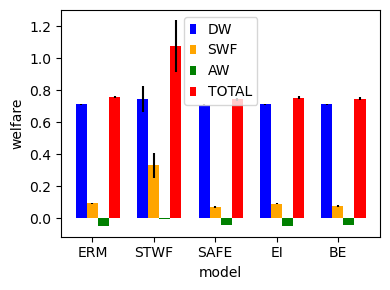

In [159]:
plot_welfare_comparison(dict_res,ebar=True)

Plot the relationship between fairness

In [16]:
def plot_long_fairness_comparison(dict_res, ebar=False):
    welfare =  {'name':models,'EI':[],'EI_var':[], 'BE':[],'BE_var':[], 'DP':[],'DP_var':[], 'EO':[], 'EO_var':[], 'EODD':[], 'EODD_var':[]}
    plt.figure(figsize = (4,3))
    plt.xlabel('model')
    plt.ylabel('unfairness')
    # Setting the positions and width for the bars
    barWidth = 0.16
    r1 = np.arange(len(models))  # positions for the first set of bars
    r2 = [x + barWidth for x in r1]  # positions for the second set of bars

    for name in models:
        welfare['EI'].append(dict_res[name]['ei_mean'])
        welfare['EI_var'].append(dict_res[name]['ei_var'])
        welfare['BE'].append(dict_res[name]['be_mean'])
        welfare['BE_var'].append(dict_res[name]['be_var'])
        welfare['DP'].append(dict_res[name]['dp_mean'])
        welfare['DP_var'].append(dict_res[name]['dp_var'])
        welfare['EO'].append(dict_res[name]['eo_mean'])
        welfare['EO_var'].append(dict_res[name]['eo_var'])
        welfare['EODD'].append(dict_res[name]['eodd_mean'])
        welfare['EODD_var'].append(dict_res[name]['eodd_var'])

    if not ebar:
        plt.bar(r1, welfare['EI'], width=barWidth, label = 'EI fairness',color = 'blue')
        plt.bar(r2, welfare['BE'], width=barWidth,label = 'BE fairness',color = 'red')

    else:
        plt.bar(r1, welfare['EI'], yerr = welfare['EI_var'], width=barWidth, label = 'EI fairness',color = 'blue')
        plt.bar(r2, welfare['BE'],  yerr = welfare['BE_var'], width=barWidth,label = 'BE fairness',color = 'red')
    
    plt.xticks([r + barWidth for r in range(len(models))], models)

    
    plt.legend(handlelength = 0.5)
    plt.tight_layout()
    if not ebar:
        plt.savefig('saved_plots/quadratic_long_fairness_comp.pdf')
    else:
        plt.savefig('saved_plots/ebar_quadratic_long_fairness_comp.pdf')




def plot_instant_fairness_comparison(dict_res, ebar=False):
    welfare =  {'name':models,'EI':[],'EI_var':[], 'BE':[],'BE_var':[], 'DP':[],'DP_var':[], 'EO':[], 'EO_var':[], 'EODD':[], 'EODD_var':[]}
    plt.figure(figsize = (4,3))
    plt.xlabel('model')
    plt.ylabel('unfairness')
    # Setting the positions and width for the bars
    barWidth = 0.16
    r1 = np.arange(len(models))  # positions for the first set of bars
    r2 = [x + barWidth for x in r1]  # positions for the second set of bars
    r3 = [x + barWidth for x in r2] # positions for the third set of bars

    for name in models:
        welfare['EI'].append(dict_res[name]['ei_mean'])
        welfare['EI_var'].append(dict_res[name]['ei_var'])
        welfare['BE'].append(dict_res[name]['be_mean'])
        welfare['BE_var'].append(dict_res[name]['be_var'])
        welfare['DP'].append(dict_res[name]['dp_mean'])
        welfare['DP_var'].append(dict_res[name]['dp_var'])
        welfare['EO'].append(dict_res[name]['eo_mean'])
        welfare['EO_var'].append(dict_res[name]['eo_var'])
        welfare['EODD'].append(dict_res[name]['eodd_mean'])
        welfare['EODD_var'].append(dict_res[name]['eodd_var'])

    if not ebar:
        plt.bar(r1, welfare['DP'], width=barWidth, label = 'DP fairness',color = 'blue')
        plt.bar(r2, welfare['EO'], width=barWidth,label = 'EO fairness',color = 'red')

    else:
        plt.bar(r1, welfare['DP'], yerr = welfare['DP_var'],width=barWidth,label = 'DP fairness', color = 'red')
        plt.bar(r2, welfare['EO'],  yerr = welfare['EO_var'],width=barWidth,label = 'EO fairness',color = 'blue')
    
    plt.xticks([r + barWidth for r in range(len(models))], models)

    
    plt.legend(handlelength = 0.5)
    plt.tight_layout()
    if not ebar:
        plt.savefig('saved_plots/quadratic_instant_fairness_comp.pdf')
    else:
        plt.savefig('saved_plots/ebar_quadratic_instant_fairness_comp.pdf')

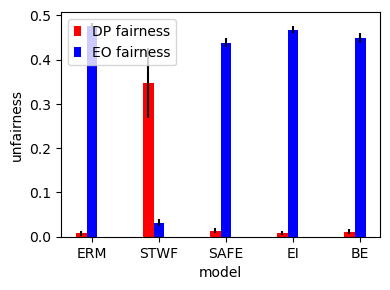

In [13]:
plot_instant_fairness_comparison(dict_res,ebar=True)

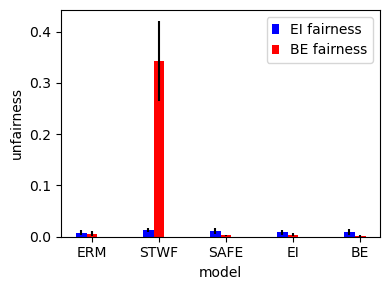

In [17]:
plot_long_fairness_comparison(dict_res,ebar=True)